Финальный проект по курсу от компании "Мегафон"
---

**Задача: сформировать персональные предложения абонентам компании "Мегафон"**

```
Задача состоит из 2-х подзадач:
1. Предсказание вероятности подключения услуги
2. Формирование индивидуальных предложений и максимизация выручки

Представлен датасет:
- откликов абонентов на те или иные продукты
- профиль потребеления абонентов
```

У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон» предлагает обширный набор различных услуг своим абонентам. При этом разным пользователям интересны разные услуги. Поэтому необходимо построить алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

**Данные**
В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.

Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.

**Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц**. 

Итого, в качестве входных данных будут представлены:
- **data_train.csv**: id, vas_id, buy_time, target
- **features.csv.zip**: id, <feature_list> 

И тестовый набор:
- data_test.csv: id, vas_id, buy_time
  - **target** - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
  - **buy_time** - время покупки, представлено в формате `timestamp`, для работы с этим столбцом понадобится функция `datetime.fromtimestamp` из модуля `datetime`.
  - **id** - идентификатор абонента
  - **vas_id** - подключаемая услуга

Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для работы с ним можно воспользоваться `pandas.read_csv`, либо можно воспользоваться библиотекой `Dask`.

**Метрика**

Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция `sklearn.metrics.f1_score(…, average='macro')`. 
[sklearn.metrics.f1_score — scikit-learn 0.22.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score)

**Формат представления результата**

1. Работающая модель в формате pickle, которая принимает файл data_test.csv из корневой папки и записывает в эту же папку файл answers_test.csv. В этом файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно записать как вероятность подключения услуги.
2. Код модели можно представить в виде jupyter-ноутбука. 
3. Презентация в формате .pdf, в которой необходимо отразить:
    - Информация о модели, ее параметрах, особенностях и основных результатах.
    - Обоснование выбора модели и ее сравнение с альтернативами.
    - Принцип составления индивидуальных предложений для выбранных абонентов.
    Рекомендуемое количество слайдов – 5 – 10.

Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и резюме необходимо прикрепить ко второму уроку "курсовой проект".

In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib2 import Path
import sys
from datetime import date

## Загрузка данных

In [2]:
path = Path('../../data/megafon/')

In [28]:
train = pd.read_csv(path.joinpath('data_train.csv'))
train

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0
...,...,...,...,...,...
831648,831648,3812226,2.0,1546203600,0.0
831649,831649,2480469,2.0,1546203600,0.0
831650,831650,158236,2.0,1546203600,0.0
831651,831651,1825525,2.0,1546203600,0.0


In [4]:
test = pd.read_csv(path.joinpath('data_test.csv'))
test

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400
3,3,1343255,5.0,1547413200
4,4,1277040,2.0,1546808400
...,...,...,...,...
71226,71226,2502453,5.0,1548018000
71227,71227,1693213,2.0,1548018000
71228,71228,1891350,2.0,1548018000
71229,71229,2437172,2.0,1548018000


<div class="alert alert-danger">
Файл features.csv загружается в оперативу 5 мин и занимает 9 Гб.
</div>

In [5]:
features = pd.read_csv(path.joinpath('features.csv'), sep='\t')
features

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4512523,4512523,3521417,1548018000,-96.799971,-29.579112,-94.900786,-40.506798,-100.318246,-61.61179,-16.08618,...,1133.626154,1497.229208,-25.996269,-36.630448,-126.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
4512524,4512524,3521563,1547413200,30.530029,-150.929112,16.589214,-34.046798,11.171754,-55.15179,-16.08618,...,-680.373846,-316.770792,-25.996269,-35.630448,-296.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
4512525,4512525,3521574,1546808400,-96.799971,-396.439112,-110.740786,-447.776798,-116.158246,-468.88179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
4512526,4512526,3521640,1547413200,38.030029,-152.519112,24.089214,-175.956798,18.671754,-197.06179,-16.08618,...,2242.626154,2528.229208,-25.996269,90.369552,-26.747724,-18.832889,-0.694428,-12.175933,0.54386,0.0


In [36]:
# размер features в памяти
sys.getsizeof(features)

9386058384

## Преобразуем `buy_time` к дате.

In [29]:
train['buy_time'] = train['buy_time'].apply(lambda data: date.fromtimestamp(data))

In [33]:
train.head(3)

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,2018-09-17,0.0
1,1,1454121,4.0,2018-07-16,0.0
2,2,2458816,1.0,2018-08-13,0.0


In [34]:
test['buy_time'] = test['buy_time'].apply(lambda data: date.fromtimestamp(data))
test.head(3)

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,2019-01-21
1,1,2000860,4.0,2019-01-21
2,2,1099444,2.0,2019-01-07
3,3,1343255,5.0,2019-01-14
4,4,1277040,2.0,2019-01-07
...,...,...,...,...
71226,71226,2502453,5.0,2019-01-21
71227,71227,1693213,2.0,2019-01-21
71228,71228,1891350,2.0,2019-01-21
71229,71229,2437172,2.0,2019-01-21


In [35]:
features['buy_time'] = features['buy_time'].apply(lambda data: date.fromtimestamp(data))
features.head(3)

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,2018-07-16,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,2018-10-15,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,2018-12-24,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0


# Обзор данных

## Распределения

### Распределение целевой переменной `target`

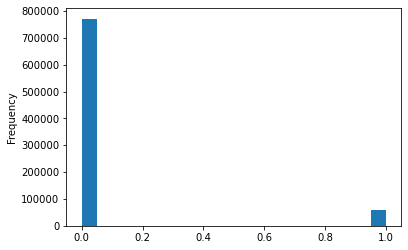

In [38]:
train['target'].plot(kind='hist',bins=20);

**Целевая переменна несбалансированна**.

### Распределение признака `vas_id`

In [47]:
train['vas_id'].nunique(), np.min(train['vas_id']), np.max(train['vas_id'])

(8, 1.0, 9.0)

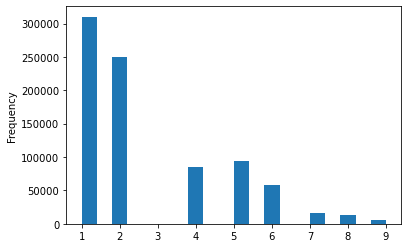

In [45]:
train['vas_id'].plot(kind='hist',bins=20);

**8 услуг с номерами от 1 до 9. Услуга под цифрой 3 отсутствует**.

In [48]:
test['vas_id'].nunique(), np.min(test['vas_id']), np.max(test['vas_id'])

(8, 1.0, 9.0)

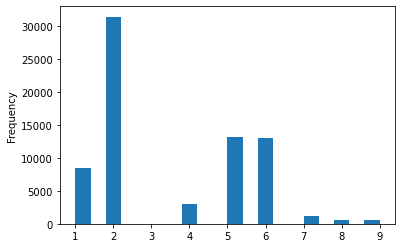

In [49]:
test['vas_id'].plot(kind='hist',bins=20);

**Распределение подключённых услуг на трейне и тесте различаются**.

### Диапазоны дат трейна и теста

In [40]:
np.min(train['buy_time']), np.max(train['buy_time'])

(datetime.date(2018, 7, 9), datetime.date(2018, 12, 31))

In [41]:
np.min(test['buy_time']), np.max(test['buy_time'])

(datetime.date(2019, 1, 7), datetime.date(2019, 1, 21))

**Трейн**:  9 июля 2018 г - 31 декабря 2018 г.

**Тест**:  7 января 2019 г - 21 января 2019 г.

### Распределение `id` абонента